# Constrained Optimization

In [1]:
%matplotlib inline
import os
import sys

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("../../"))

In [2]:
import numpy as np

import desc
from desc.grid import LinearGrid
from desc import objectives
from desc.optimize import Optimizer
from desc.plotting import plot_1d, plot_section, plot_surfaces
import desc.examples

DESC version 0.8.2+32.g1abdcb64.dirty,using JAX backend, jax version=0.4.1, jaxlib version=0.4.1, dtype=float64
Using device: CPU, with 9.88 GB available memory


In this example we'll use a constrained optimizer to optimize a simple tokamak for Mercier stability. We'll start with a Solovev equilibrium.

In [3]:
eq = desc.examples.get("SOLOVEV")

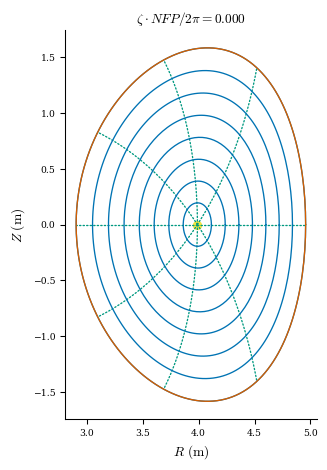

In [4]:
plot_surfaces(eq);

We see that this has a slight negative triangularity, but unfortunately, it is Mercier unstable, as indicated by the negative magnetic well.

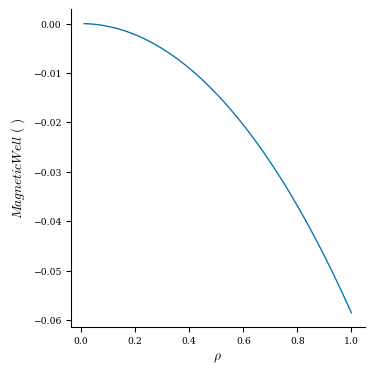

In [5]:
plot_1d(eq, "magnetic well");

To set up the optimization problem we'll start with constraints. We want to keep the major radius fixed as well as the profiles and total flux:

In [6]:
constraints = (
    objectives.FixBoundaryR(modes=[[0, 0, 0]]),  # fix specified major axis position
    objectives.FixPressure(),  # fix pressure profile
    objectives.FixIota(),  # fix rotational transform profile
    objectives.FixPsi(),  # fix total toroidal magnetic flux
)

We also obviously want to maintain MHD equilibrium, which we do by imposing force balance as a constraint. In practice, it helps to treat it as an inequality constraint, so here we merely enforce that the normalized error should be $< 10^{-4}$

In [7]:
constraints += (objectives.ForceBalance(bounds=(-1e-4, 1e-4), normalize_target=False),)

Next, we would like to keep the overall size of the equilibrium roughly the same. We could do this by further limiting the Fourier modes of the boundary shape using the `FixBoundaryR` constraint above, but we can also simple impose that the total volume and aspect ratio remain unchanged.

In [8]:
constraints += (
    objectives.AspectRatio(target=eq.compute("R0/a")["R0/a"]),
    objectives.Volume(target=eq.compute("V")["V"]),
)

Finally, we want to make sure our final equilibrium is Mercier stable - ie, it should have a positive magnetic well. We'll do this by targeting the magnetic well at 10 different radial locations, and enforce that it is slightly greater than 0.

In [9]:
constraints += (
    objectives.MagneticWell(
        bounds=(0, np.inf),
        grid=LinearGrid(
            M=eq.M_grid,
            N=eq.N_grid,
            NFP=eq.NFP,
            sym=eq.sym,
            rho=np.linspace(0.1, 0.9, 10),
        ),
    ),
)

Now that we've defined our constraints we need to define our objectives. We know that in stellarators, strong "bean" shaping is usually favorable for stability, however it can make coil design difficult. We can penalize this behavior by targeting the mean curvature of the surface. Positive mean curvature indicates "concave" areas, which can be hard to create without complex coils. 

In this case, we don't really care about negative curvature, so we'll apply a 1 sided objective of the form $L = \min(0, f)^2$ by specifying the bounds as -infinity and 0

In [10]:
objective = objectives.ObjectiveFunction(objectives.MeanCurvature(bounds=(-np.inf, 0)))

Next, we choose an optimizer that can handle constraints. We'll use one from `scipy`, that while not the most efficient, is easy to use.

In [16]:
optimizer = Optimizer("scipy-SLSQP")

Finally, we'll run the optimization:

In [17]:
eq2, result = eq.optimize(
    objective=objective,
    constraints=constraints,
    optimizer=optimizer,
    maxiter=500,
    copy=True,
    verbose=3,
    # options={"verbose":3, "disp":True, "initial_barrier_parameter":1e-3},
)

Timer: Linear constraint projection build = 461 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 748 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 440 ms
Building objective: volume
Precomputing transforms
Timer: Precomputing transforms = 459 ms
Building objective: Magnetic Well
Precomputing transforms
Timer: Precomputing transforms = 444 ms
Timer: Objective build = 4.13 sec
Timer: Linear constraint projection build = 4.38 sec
Compiling objective function and derivatives: ['mean-curvature']
Timer: Objective compilation time = 124 us
Timer: Gradient compilation time = 223 us
Timer: Total compilation time = 3.58 ms
Compiling objective function and derivatives: ['force', 'aspect ratio', 'volume', 'Magnetic Well']
Timer: Objective compilation time = 5.18 sec
Timer: Jacobian compilation time = 12.7 sec
Timer: Total compilation time = 17.9 sec
Number of parameters: 246
Number of objectives: 37
Number of equali

/home/fouriest/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:525: OptimizeWarning: Equality and inequality constraints are specified in the same element of the constraint list. For efficient use with this method, equality and inequality constraints should be specified in separate elements of the constraint list. 
  warn("Equality and inequality constraints are specified in the same "


       1              1         0.0000e+00                                    0.00e+00            1.79e-02        
         Current function value: 0.000e+00
         Max constraint violation: 4.568e+08
         Total delta_x: 4.495e+04
         Iterations: 1
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 0
Timer: Solution time = 18.6 sec
Timer: Avg time per step = 9.31 sec
Start of solver
Total (sum of squares):  0.000e+00, 
Mean curvature:  0.000e+00 (m^-1)
Mean curvature:  0.000e+00 (normalized)
R boundary error:  0.000e+00 (m)
R boundary error:  0.000e+00 (normalized)
Fixed-pressure profile error:  0.000e+00 (Pa)
Fixed-pressure profile error:  0.000e+00 (normalized)
Fixed-iota profile error:  0.000e+00 (dimensionless)
Fixed-Psi error:  0.000e+00 (Wb)
Fixed-Psi error:  0.000e+00 (normalized)
Total force:  0.000e+00 (N)
Total force:  0.000e+00 (normalized)
Aspect ratio:  4.441e-16 (dimensionless)
Aspect ratio:  4.441e-16 (normalized)
P

Because we only imposed force balance approximately during the optimization, it is useful to re-solve the final equilibrium to further reduce the MHD error.

In [13]:
eq2.solve();

Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 222
Number of objectives: 380
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 4.541e-11
         Total delta_x: 3.228e-02
         Iterations: 30
         Function evaluations: 40
         Jacobian evaluations: 31
Start of solver
Total (sum of squares):  8.785e-07, 
Total force:  2.100e+02 (N)
Total force:  1.326e-03 (normalized)
End of solver
Total (sum of squares):  4.541e-11, 
Total force:  1.510e+00 (N)
Total force:  9.530e-06 (normalized)


Plotting the flux surfaces, we see that the equilibrium now has positive triangularity, which is expected for Mercier stability

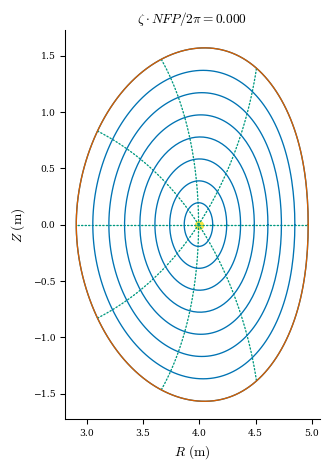

In [14]:
plot_surfaces(eq2);

And to confirm, we can look at the magnetic well for the final configuration to ensure its positive:

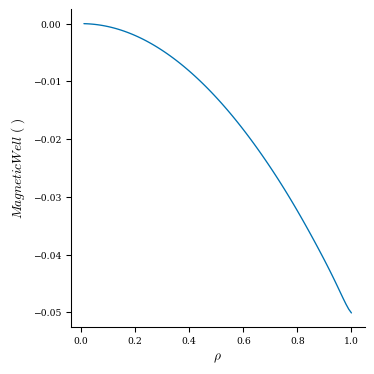

In [15]:
plot_1d(eq2, "magnetic well");